# Gradient scales

In this notebook we will take a look at a simple training setting.

And then we will confront one of the big challenges that faced neural network practitioners for 20 years: the challenge of gradient scaling.

* If derivatives are too large, then you get explosions when doing gradient descent.
* If derivatives are too small, then your optimizer goes nowhere.
* And the worst case is when the derivatives are both small and large in the same system.



## Show set-up code

In [ ]:
# This visulaization function is used for the next example

%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np

def deviceof(net):
    return next(net.parameters()).device

def visualize_net(net, classify_target):
    fig, axd = plt.subplot_mosaic("AB\nAB\nCC")
    ax1, ax2, ax3 = [axd[k] for k in "ABC"]
    if net:
        grad_hist(net, ax3)
    grid = torch.stack([
        torch.linspace(-2, 2, 100)[None, :].expand(100, 100),
        torch.linspace(2, -2, 100)[:, None].expand(100, 100),
    ])
    x, y = grid
    target = classify_target(x, y)
    ax1.set_title('target')
    ax1.imshow(target.float(), cmap='hot', extent=[-2,2,-2,2])
    if net:
        ax2.set_title('network output')
        score = net(grid.permute(1, 2, 0).reshape(-1, 2).to(deviceof(net))).softmax(1)
        ax2.imshow(score[:,1].reshape(100, 100).detach().cpu(), cmap='hot', extent=[-2,2,-2,2])
    plt.show()

# Function to draw a histogram of all the gradients
def grad_hist(net, ax):
    all_grads = []
    for p in net.parameters():
        if p.grad is not None:
            all_grads.append(p.grad.detach().cpu().flatten())
    all_grads = torch.cat(all_grads).abs().clamp(1e-9)
    _, bins = np.histogram(np.log10(all_grads), bins='auto')
    ax.hist(all_grads, bins=10**bins)
    ax.set_xscale('log')

## Define a three-layer MLP

We'll start with a defining a neural network.


In [ ]:
import torch, math
from torch.nn.functional import cross_entropy
from collections import OrderedDict
from torch.nn import Linear, ReLU, Sequential
from torch.optim import Adam, SGD


# Defining a three-layer MLP.
mlp = torch.nn.Sequential(OrderedDict([
    ('layer1', Sequential(Linear(2, 20), ReLU())),
    ('layer2', Sequential(Linear(20, 20), ReLU())),
    ('layer3', Sequential(Linear(20, 2)))
]))

print(mlp)



Sequential(
  (layer1): Sequential(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): ReLU()
  )
  (layer2): Sequential(
    (0): Linear(in_features=20, out_features=20, bias=True)
    (1): ReLU()
  )
  (layer3): Sequential(
    (0): Linear(in_features=20, out_features=2, bias=True)
  )
)


## Defining the training set

Here we define a toy problem: given a point (x, y), define whether it is in class 0 or 1 using a simple (but nonlinear) mathematical rule.

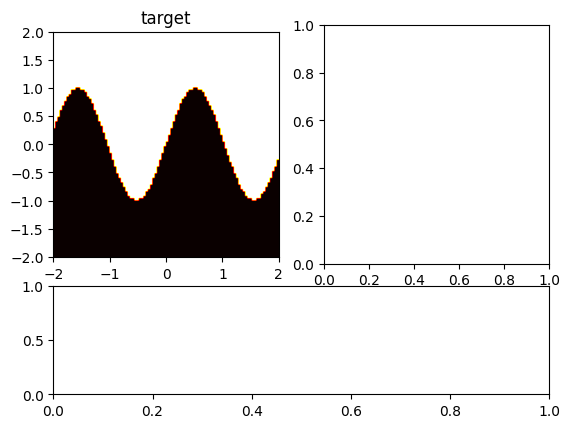

In [ ]:
# Setup: define the training set.
def classify_target(x, y):
    return (y > (x * 3).sin()).long()

visualize_net(None, classify_target)

## The four parts of a training loop

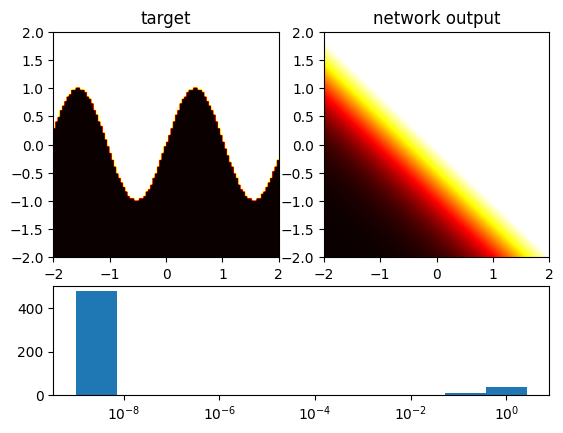

Iteration 0 accuracy: 0.5


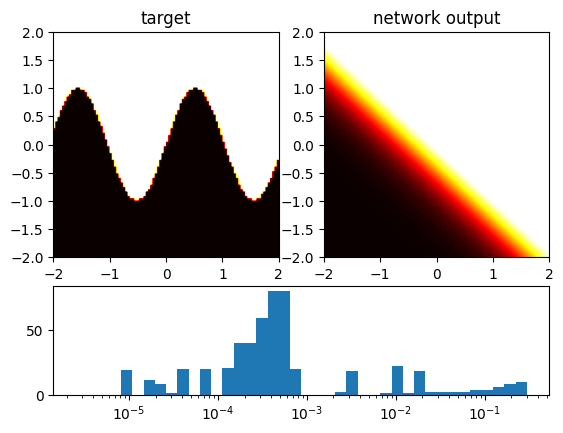

Iteration 1 accuracy: 0.6567999720573425


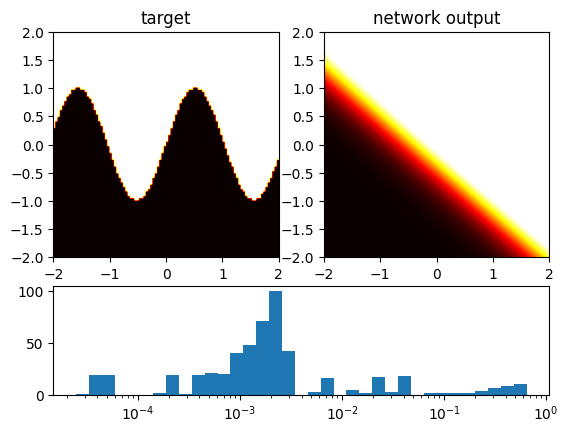

Iteration 3 accuracy: 0.6575999855995178


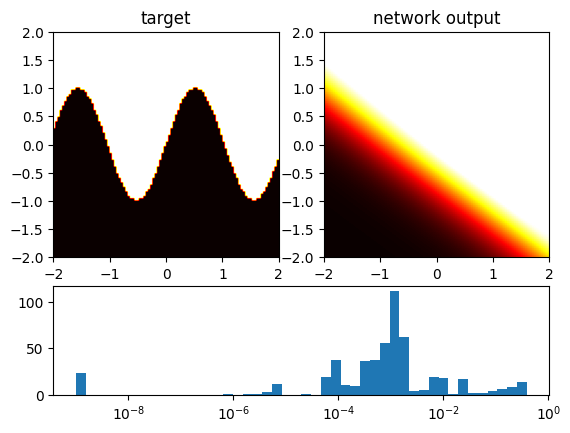

Iteration 7 accuracy: 0.6814000010490417


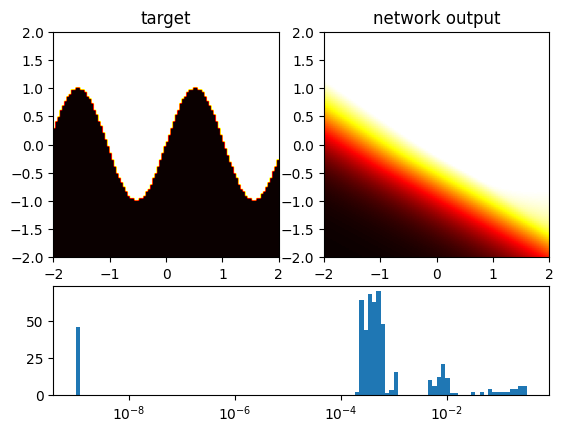

Iteration 15 accuracy: 0.6906999945640564


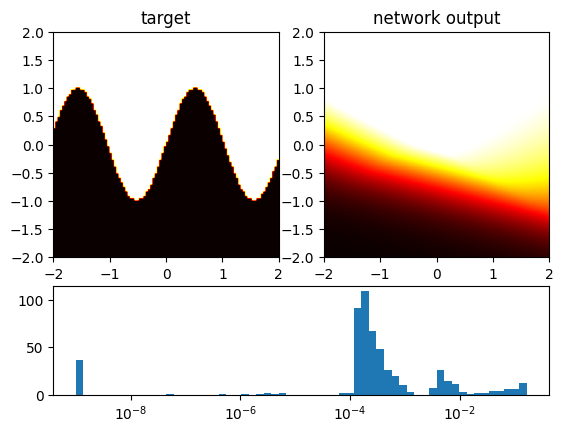

Iteration 31 accuracy: 0.7484999895095825


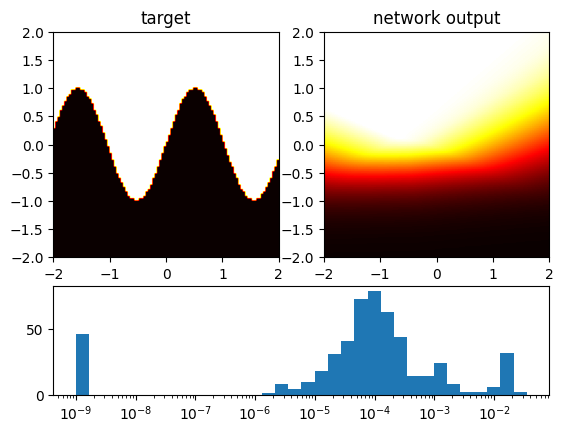

Iteration 63 accuracy: 0.7580000162124634


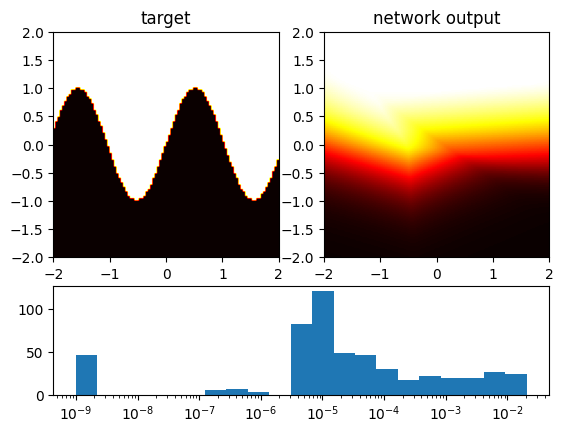

Iteration 127 accuracy: 0.7962999939918518


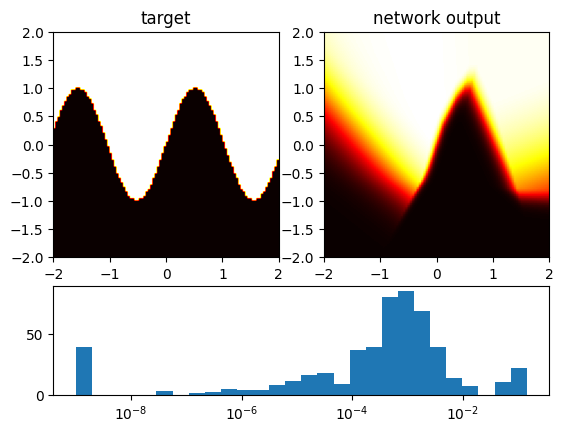

Iteration 255 accuracy: 0.9358000159263611


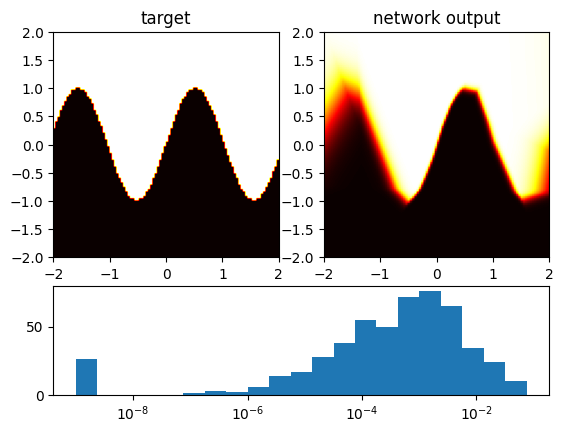

Iteration 511 accuracy: 0.9884999990463257


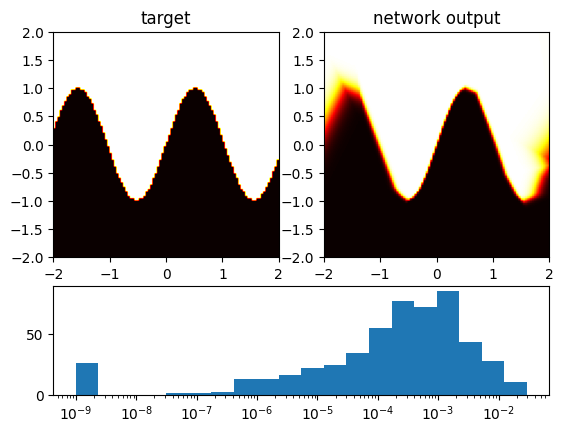

Iteration 1023 accuracy: 0.9918000102043152


In [ ]:
from string import printable
def ocassional(iteration):
    return iteration == 2 ** iteration.bit_length() - 1

# initialize the network somehow
for i, p in enumerate(mlp.parameters()):
    #p.data.uniform_(-1,1)
    p.data[...] = torch.linspace(0, i % 3 - 1, p.numel()).reshape(p.shape)

optimizer = Adam(mlp.parameters(), lr=0.01)
for iteration in range(1024):

    # Step 1: sample the training data
    in_batch = torch.randn(10000, 2, device=deviceof(mlp))
    target_batch = classify_target(in_batch[:,0], in_batch[:,1])

    # Step 2: compute the loss
    out_batch = mlp(in_batch)
    loss = cross_entropy(out_batch, target_batch)

    # Step 3: update the weights
    mlp.zero_grad()
    loss.backward()
    optimizer.step()

    # Step 4: test performance on different data
    if ocassional(iteration):
        with torch.no_grad():
            visualize_net(mlp, classify_target)
            pred_batch = out_batch.max(1)[1]
            accuracy = (pred_batch == target_batch).float().sum() / len(in_batch)
            print(f'Iteration {iteration} accuracy: {accuracy}')


## Initialization: exercises to do

Try changing the weight initialization rule above.  Can we make it behave better?

## Momentum and ADAM: Exercises to do.

1. Implement our own GD.
2. Write a simple EMA function.
3. Track an EMA of the gradient.
4. Track and plot EMA of RMS.
5. Try to put it together as ADAM.
6. Fix the EMA function.

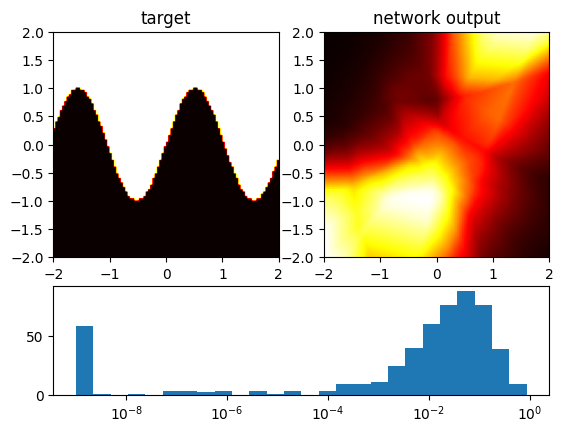

Iteration 0 accuracy: 0.40220001339912415


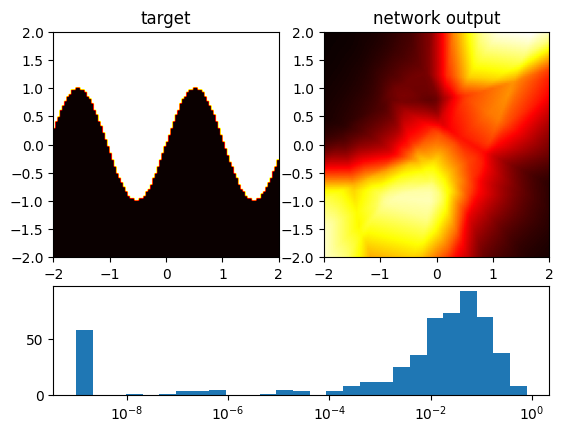

Iteration 1 accuracy: 0.4156000018119812


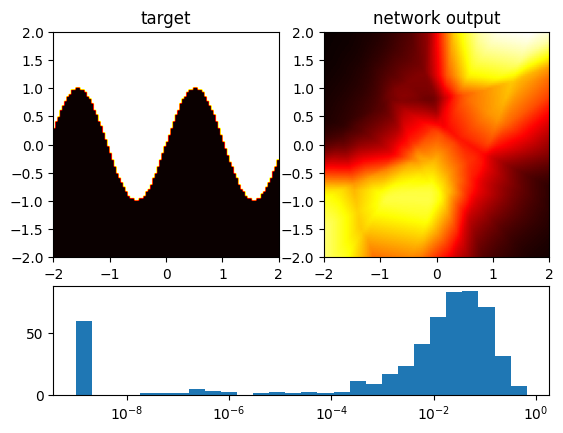

Iteration 3 accuracy: 0.4408999979496002


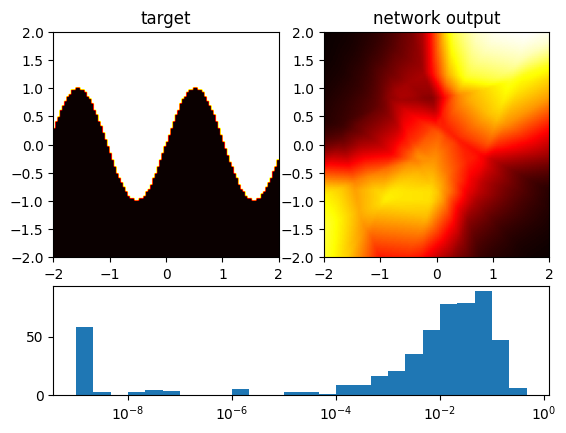

Iteration 7 accuracy: 0.5113999843597412


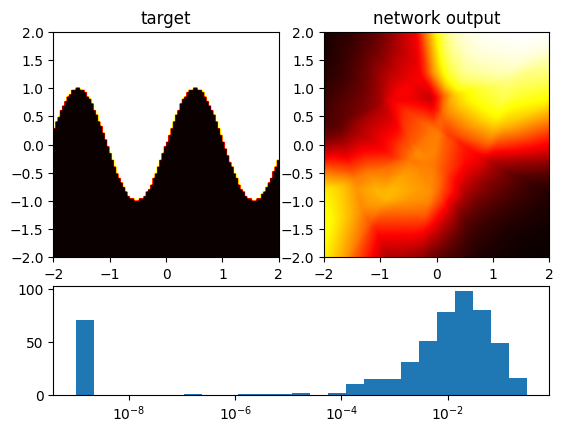

Iteration 15 accuracy: 0.5647000074386597


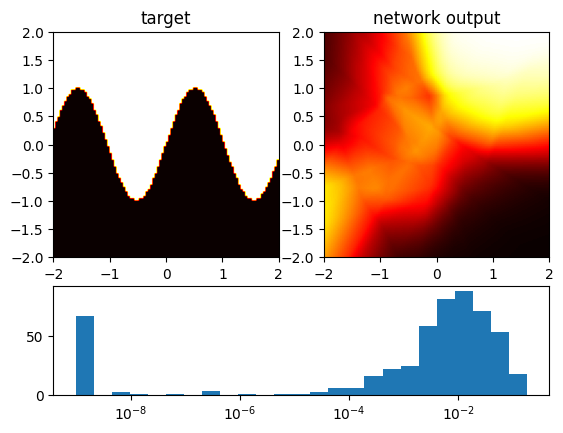

Iteration 31 accuracy: 0.7041000127792358


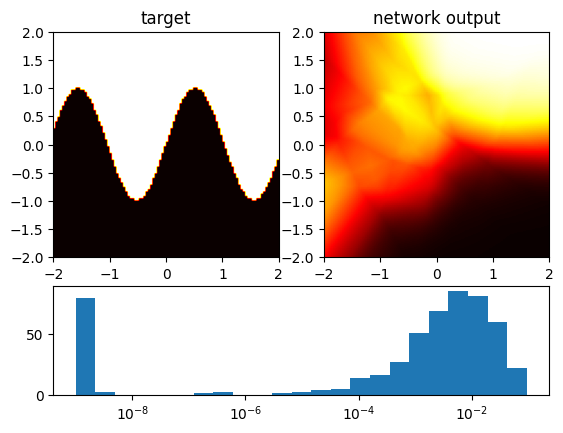

Iteration 63 accuracy: 0.7768999934196472


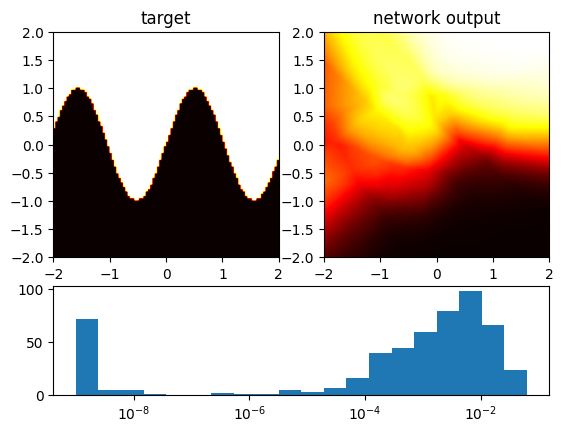

Iteration 127 accuracy: 0.8111000061035156


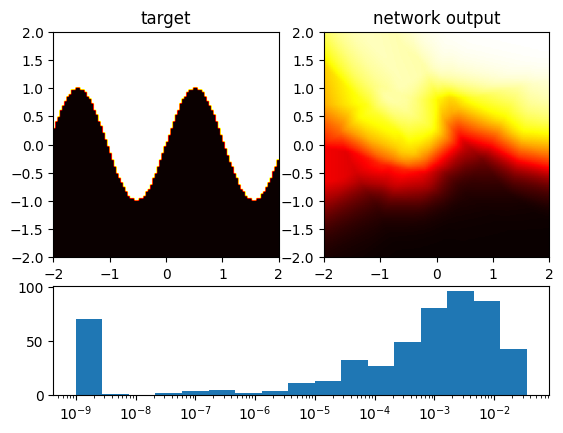

Iteration 255 accuracy: 0.8367000222206116


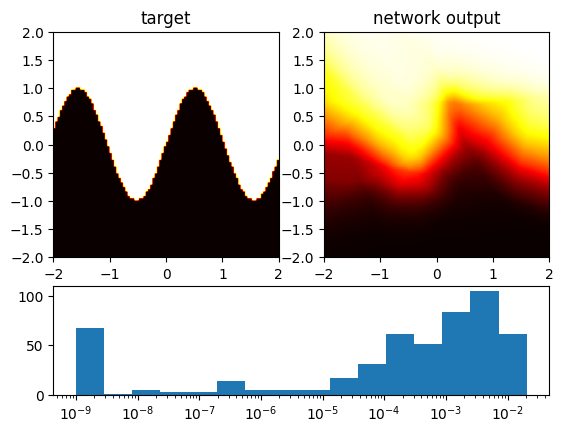

Iteration 511 accuracy: 0.862500011920929


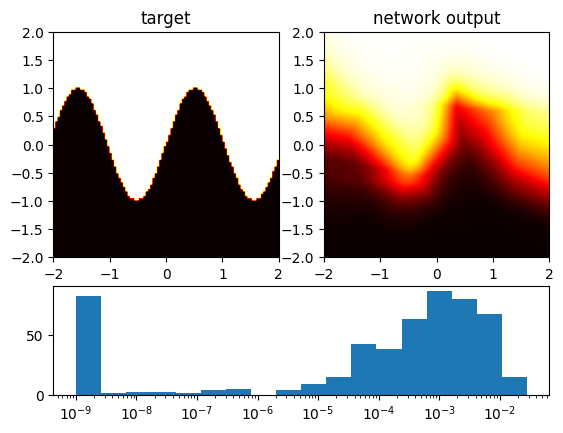

Iteration 1023 accuracy: 0.8881000280380249


In [ ]:
from string import printable
def ocassional(iteration):
    return iteration == 2 ** iteration.bit_length() - 1

# initialize the network somehow
for i, p in enumerate(mlp.parameters()):
    p.data.uniform_(-1,1)

optimizer = SGD(mlp.parameters(), lr=0.01)

v = [torch.zeros_like(p) for p in mlp.parameters()]

for iteration in range(1024):

    # Step 1: sample the training data
    in_batch = torch.randn(10000, 2, device=deviceof(mlp))
    target_batch = classify_target(in_batch[:,0], in_batch[:,1])

    # Step 2: compute the loss
    out_batch = mlp(in_batch)
    loss = cross_entropy(out_batch, target_batch)

    # Step 3: update the weights
    mlp.zero_grad()
    loss.backward()
    for p in mlp.parameters():
      p.data -= p.grad * 0.01

    # Step 4: test performance on different data
    if ocassional(iteration):
        with torch.no_grad():
            visualize_net(mlp, classify_target)
            pred_batch = out_batch.max(1)[1]
            accuracy = (pred_batch == target_batch).float().sum() / len(in_batch)
            print(f'Iteration {iteration} accuracy: {accuracy}')


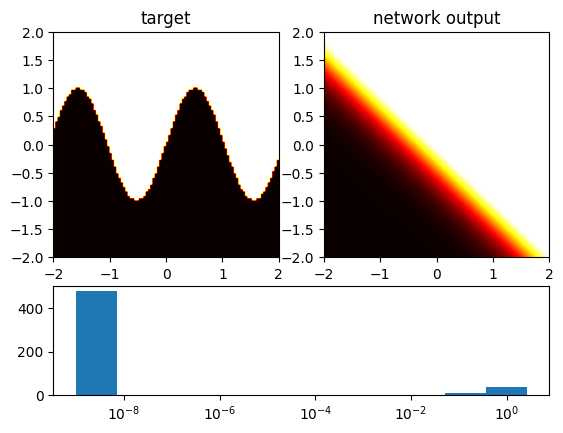

Iteration 0 accuracy: 0.49570000171661377


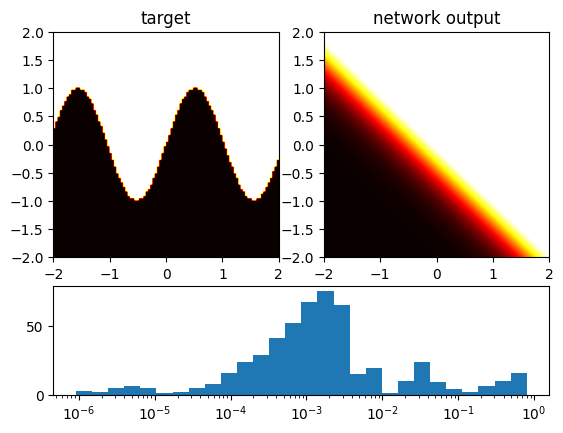

Iteration 1 accuracy: 0.6462000012397766


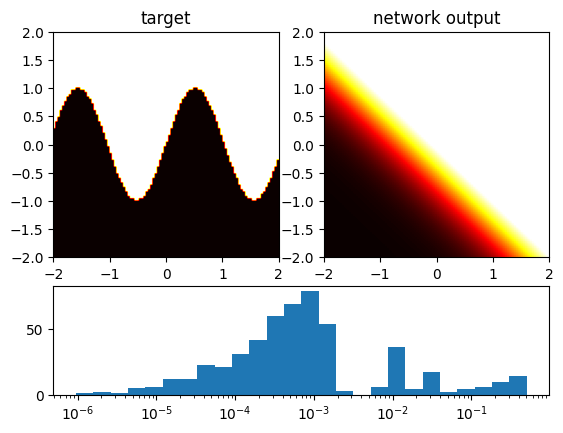

Iteration 3 accuracy: 0.6599000096321106


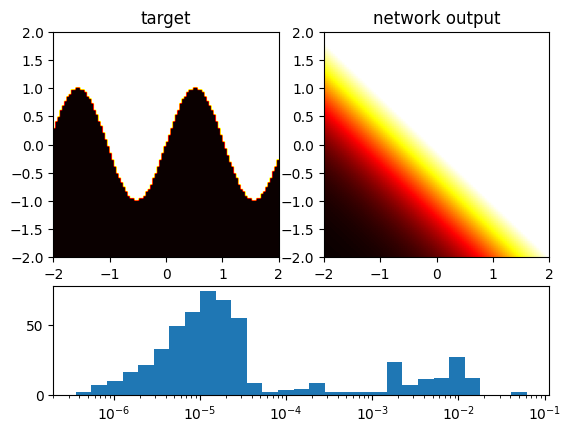

Iteration 7 accuracy: 0.6561999917030334


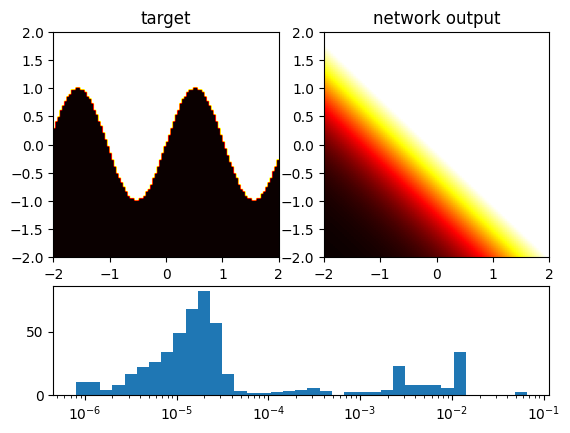

Iteration 15 accuracy: 0.6553999781608582


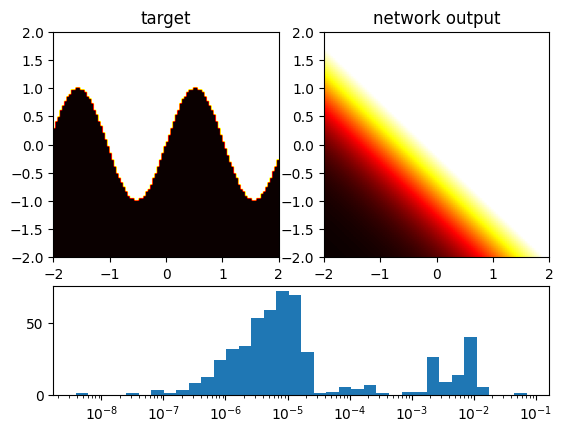

Iteration 31 accuracy: 0.6500999927520752


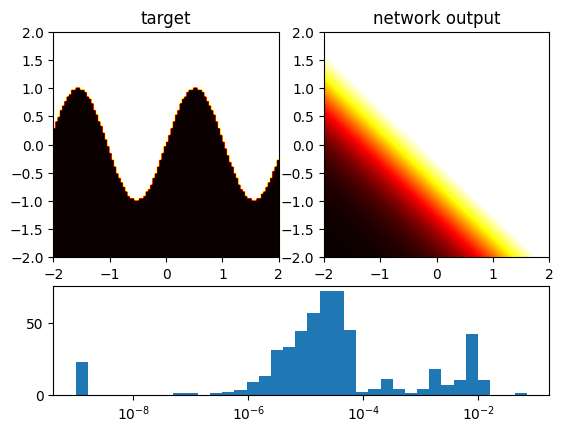

Iteration 63 accuracy: 0.6628999710083008


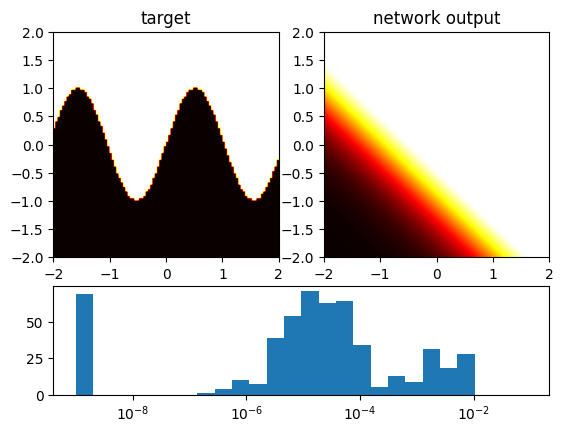

Iteration 127 accuracy: 0.6424999833106995


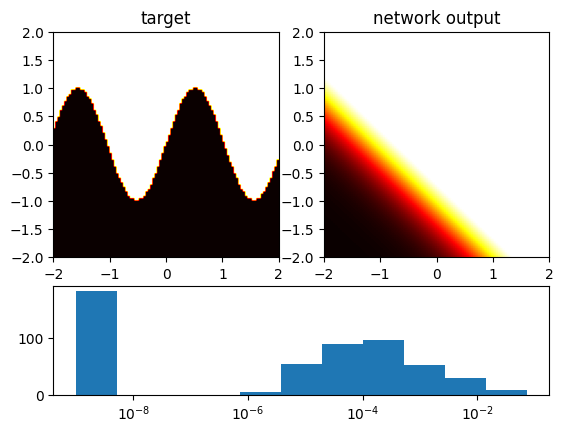

Iteration 255 accuracy: 0.6514999866485596


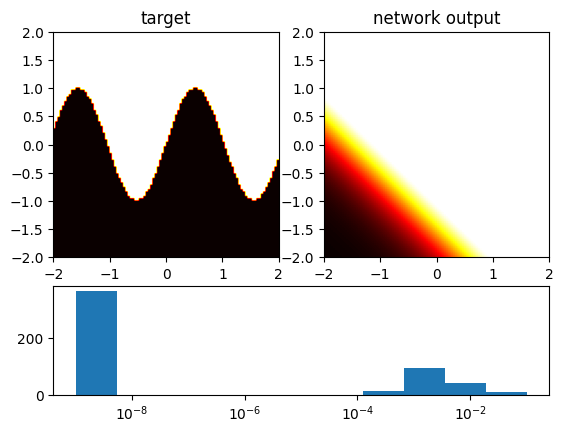

Iteration 511 accuracy: 0.6202999949455261


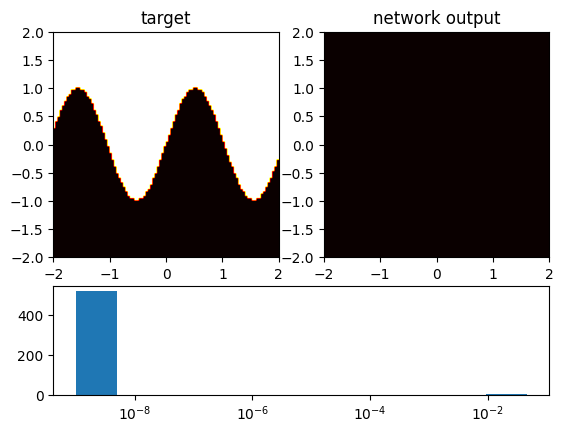

Iteration 1023 accuracy: 0.5005999803543091


In [ ]:
class MyOptimizer:
    def __init__(self, params, lr):
        self.params = params
        self.lr = lr

    def step(self):
        for p in self.params:
            p.data -= self.lr * p.grad

run_training(MyOptimizer)